<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Forest Fires
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning</b> <br>  <b>AY 2021/2022</b> <br>
    Emanuele Cavalleri<br>(matriculation number: <b>995883</b>)<br>
    <a href="mailto:emanuele.cavalleri@mail.polimi.it">emanuele.cavalleri@mail.polimi.it</a><br>
    <a href="https://github.com/emanuelecavalleri/MLForestFires">GitHub link for this project</a><br>
    </div>
</tr>
</table>

The aim of this machine learning project is to predict the burned area of forest fires in Montesinho park, in the northeast region of Portugal, by using meteorological and other data.<br>
 <img src="https://photo620x400.mnstatic.com/d5064990d15d1075a0485634955b0e26/montesinho-natural-park.jpg?quality=70&format=pjpg"> 

# Dependencies

In [1]:
%%capture
%pip install mlxtend

In [2]:
# Run this code to make Jupyter print every printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy
from scipy.stats import zscore
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,LassoLarsCV,RidgeCV
from scipy.stats import t, f
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import itertools
import statsmodels.api as sm
import statsmodels.stats.api as sms
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Load and describe data

In [3]:
# Read the data and create a pandas DataFrame
ff_data = pd.read_csv("forestfires.csv")
# Dataframe's dimensions
ff_data.shape

(517, 13)

In [4]:
# Print the first few (5 by default) rows of the dataset
print(ff_data.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51  6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7    18  33  0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33  1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5    9   8.3  97    4   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99  1.8   0.0   0.0


In [5]:
# Types of the columns
ff_data.dtypes

X          int64
Y          int64
month     object
day       object
FFMC      object
DMC      float64
DC        object
ISI       object
temp      object
RH         int64
wind      object
rain     float64
area     float64
dtype: object

Let's start analyzing the dataset column by column.
<ul>
    <li><b><i>X</i></b> := x-axis spatial coordinate within the Montesinho park map: $1$ to $9$</li>
    <li><b><i>Y</i></b> := y-axis spatial coordinate within the Montesinho park map: $2$ to $9$</li>
</ul>

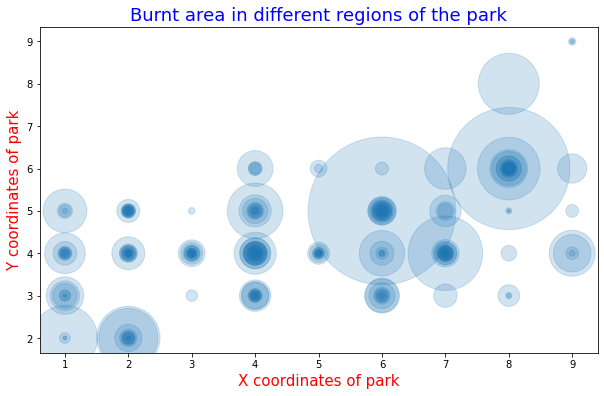

In [6]:
# Analysis of Burnt area based on spatial coordinates(X,Y)
_ = ff_data.plot(kind='scatter', x='X', y='Y', alpha=0.2, s=20*ff_data['area'],figsize=(10,6))
_ = plt.xlabel('X coordinates of park',color='red',fontsize=15)
_ = plt.ylabel('Y coordinates of park',color='red',fontsize=15)
_ = plt.title('Burnt area in different regions of the park',color='blue',fontsize=18)

<ul>
    <li><i><b>month</b></i> := month of the year: "jan" to "dec"; months are an important information because of the seasonality of weather</li>
</ul>   

In [7]:
ff_data['month'].value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

<i>month</i> column does not contain misleading values.

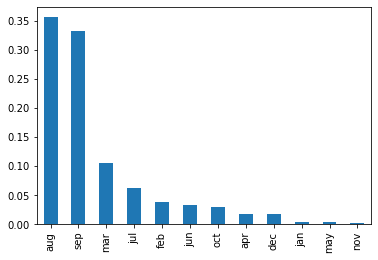

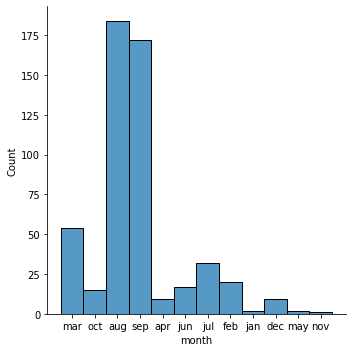

In [8]:
_ = ff_data['month'].value_counts(normalize=True).plot.bar()
_ = sns.displot(data=ff_data['month'])

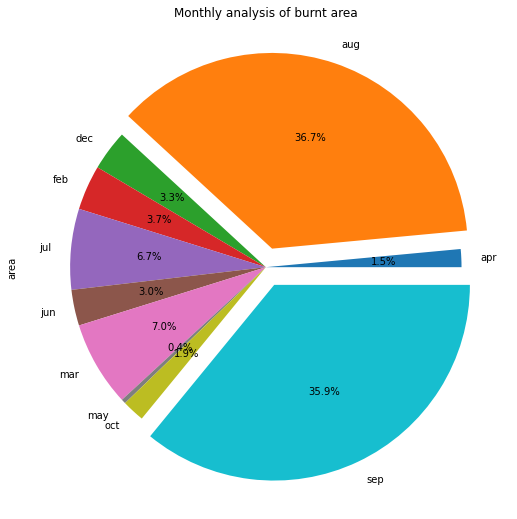

In [9]:
areaburnt = ff_data[ff_data['area'] > 0] # if an area is burnt, then area must be > 0
_ = areaburnt.groupby('month')['area'].agg('count').plot(kind='pie', title='Monthly analysis of burnt area',
                                                     figsize=(9,9), explode=[0,0.1,0,0,0,0,0,0,0,0.1],
                                                     autopct='%0.1f%%')
plt.show()

It is interesting to see that abnormally high number of the forest fires occur in the month of August and September.

<ul>
    <li><b><i>day</b></i> := day of the week: "mon" to "sun"; dates are an important information because working days have less visitors than holidays</li>
</ul>  

In [10]:
ff_data['day'].value_counts()

sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

<i>day</i> does not contain misleading values too. 

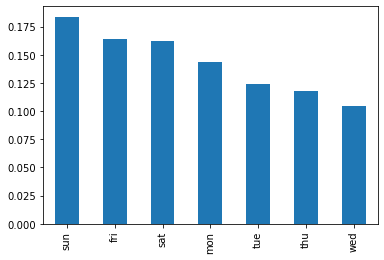

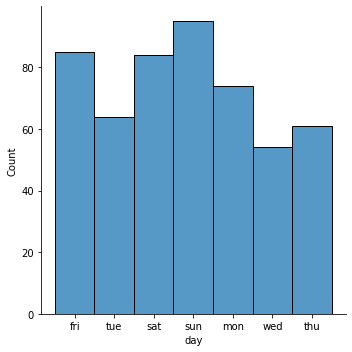

In [11]:
_ = ff_data['day'].value_counts(normalize=True).plot.bar()
_ = sns.displot(data=ff_data['day'])

In the case of <i>day</i>, the days Friday to Monday have higher proportion of cases.

<ul>
    <li><b><i>FFMC</i></b> := FFMC index from the FWI system: $18.7$ to $96.20$ *</li>
    <li><b><i>DMC</i></b> := DMC index from the FWI system: $1.1$ to $291.3$ *</li>
    <li><b><i>DC</i></b> := DC index from the FWI system: $7.9$ to $860.6$ *</li>
    <li><b><i>ISI</i></b> := ISI index from the FWI system: $0.0$ to $56.10$ *</li>
</ul>
* Fine Fuel Moisture Code (FFMC), Duff Moisture Code (DMC), Drought Code (DC), Initial Spread Index (ISI).  The first three are related to fuel codes: the FFMC denotes the moisture content surface litter and influences ignition and fire spread, while the DMC and DC represent the moisture content of shallow and deep organic layers, which affect fire intensity. The ISI is a score that correlates with fire velocity spread. Fuel codes require a memory (time lag) of past weather conditions: $16$ hours for FFMC, $12$ days for DMC and $52$ days for DC.

<i>FFMC</i>, <i>DC</i> and <i>ISI</i> columns do contain some 'Missing' strings. Let's fix this issue.

In [12]:
# 'Missing' strigs treated as nan
ff_data['FFMC'] = pd.to_numeric(ff_data['FFMC'], errors='coerce')
ff_data['DC'] = pd.to_numeric(ff_data['DC'], errors='coerce')
ff_data['ISI'] = pd.to_numeric(ff_data['ISI'], errors='coerce')

<ul>
    <li><b><i>temp</i></b> := temperature in Celsius degrees: $2.2$ to $33.30$ **</li>
    <li><b><i>RH</i></b> := relative humidity in %: $15.0$ to $100$ **</li>
    <li><b><i>wind</i></b> := wind speed in km/h: $0.40$ to $9.40$ **</li>
    <li><b><i>rain</i></b> := outside rain in mm/m2 : $0.0$ to $6.4$ **</li>
</ul>
** Temperature, relative humidity, wind have values that denote instant records, as given by the station sensors when the fire was detected. Rain variable instead denotes the accumulated precipitation within the previous $30$ minutes.

<i>temp</i> and <i>wind</i> columns do contain some 'Missing' strings too. Let's fix this issue as before.

In [13]:
ff_data['temp'] = pd.to_numeric(ff_data['temp'], errors='coerce')
ff_data['wind'] = pd.to_numeric(ff_data['wind'], errors='coerce')

In [14]:
# Check new types of columns
ff_data.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

Everything is ok now.

Since nan values are just...

In [15]:
ff_data.isna().sum()
ff_data.isna().sum().sum()

X        0
Y        0
month    0
day      0
FFMC     1
DMC      0
DC       1
ISI      2
temp     2
RH       0
wind     1
rain     0
area     0
dtype: int64

7

we can safely remove their rows.

In [16]:
ff_data.dropna(inplace = True)

In [17]:
ff_data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,510.0,4.650980,2.314163,1.0,3.000,4.000,7.0000,9.00
Y,510.0,4.298039,1.232100,2.0,4.000,4.000,5.0000,9.00
FFMC,510.0,90.635686,5.552774,18.7,90.200,91.600,92.9000,96.20
DMC,510.0,110.812157,64.103740,1.1,68.875,108.300,142.1250,291.30
DC,510.0,547.918627,248.667923,7.9,434.400,664.200,713.9000,860.60
ISI,510.0,9.017059,4.571755,0.0,6.500,8.400,10.7750,56.10
temp,510.0,18.880196,5.820904,2.2,15.500,19.300,22.8000,33.30
RH,510.0,44.350980,16.359792,15.0,33.000,42.000,53.0000,100.00
wind,510.0,4.008824,1.793894,0.4,2.700,4.000,4.9000,9.40
rain,510.0,0.021961,0.297976,0.0,0.000,0.000,0.0000,6.40


Let's now have a look at numerical columns (for the time being we exclude target variable <i>area</i>).

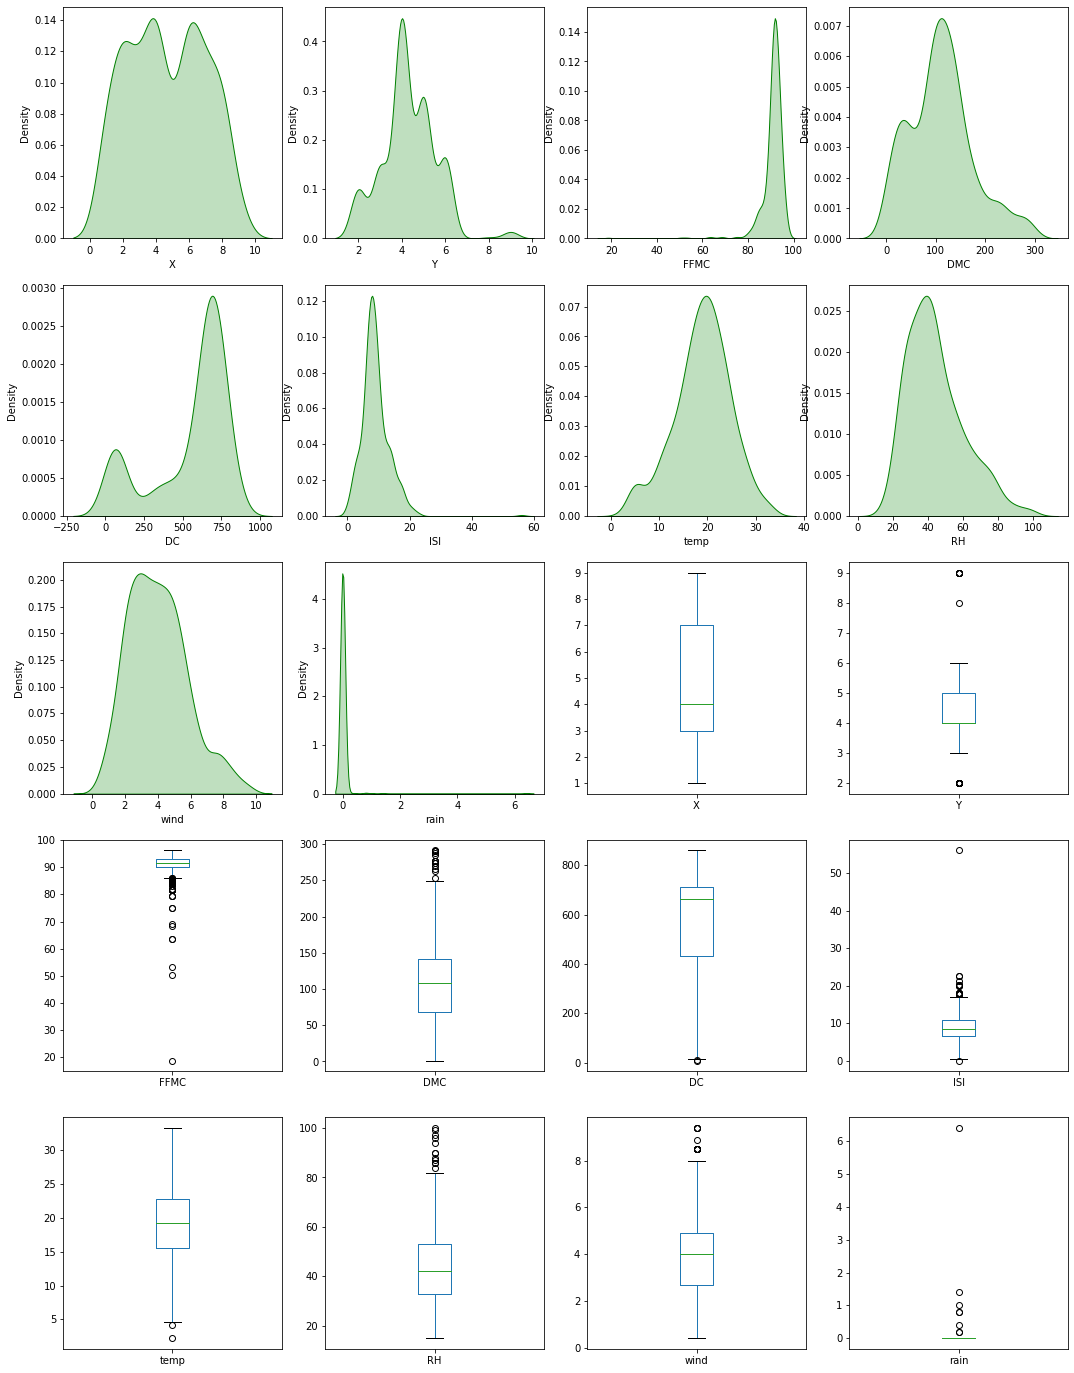

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.045490,0.41718,-6.544837,0.546850,-1.097583,2.549528,-0.330697,0.858355,0.592403,19.681696
kurtosis,-1.168781,1.43551,66.340467,0.211169,-0.255635,21.534243,0.129587,0.427177,0.076966,415.588981


In [18]:
target = 'area'
num_columns = ff_data.drop(columns=target).select_dtypes(exclude='object').columns.tolist()

_ = plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    _ = plt.subplot(8,4,i)
    _ = sns.kdeplot(ff_data[col],color='g',shade=True)
    _ = plt.subplot(8,4,i+10)
    _ = ff_data[col].plot.box()
plt.show()

pd.DataFrame(data=[ff_data[num_columns].skew(),ff_data[num_columns].kurtosis()],index=['skewness','kurtosis'])

Outliers, Skewness and kurtosis (high positive or negative) was observed in <i>FFMC</i>, <i>ISI</i>  and <i>rain</i> columns.

<ul>
    <li><b><i>area</i></b> := the burned area of the forest (in ha): $0.00$ to $1090.84$ (this output variable is very skewed towards $0.0$, thus it may make sense to model with the logarithm transform).</li>
</ul>

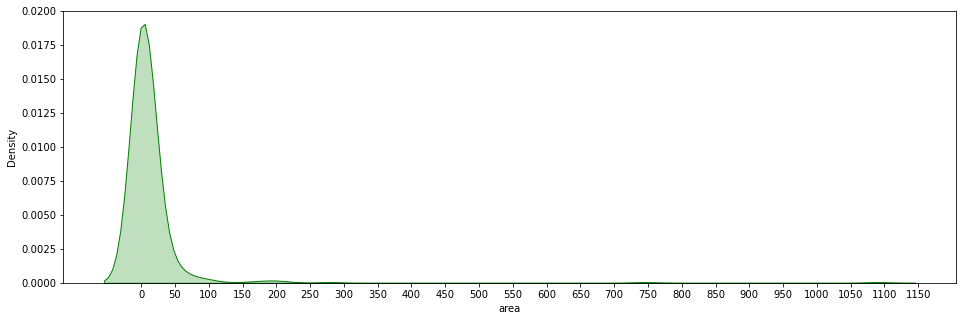

Skew: 12.76272789636751
Kurtosis: 191.5733868303203


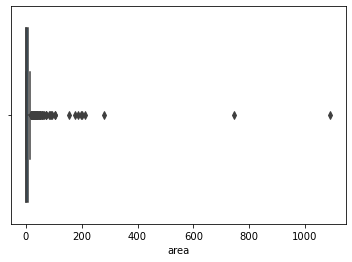

In [19]:
_ = plt.figure(figsize=(16,5))
_ = sns.kdeplot(ff_data[target],shade=True,color='g')
_ = plt.xticks([i for i in range(0,1200,50)])
plt.show()
print("Skew: {}".format(ff_data[target].skew()))
print("Kurtosis: {}".format(ff_data[target].kurtosis()))

_ = sns.boxplot(x=ff_data[target])

The data is highly skewed with a value of $+12.76$ and huge kurtosis value of $192$.

It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under $50$ hectares of land.

In [20]:
# Outlier points
y_outliers = ff_data[abs(zscore(ff_data[target])) >= 3]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


There are four outlier instances in our <i>area</i> column, we'll get back to this in the outlier treatment step.<br>
To recap, outliers are present in <i>area</i>, <i>FFMC</i>, <i>ISI</i> and <i>rain</i> data. In order to minimize the effect of outliers in our model we will transform the above features.

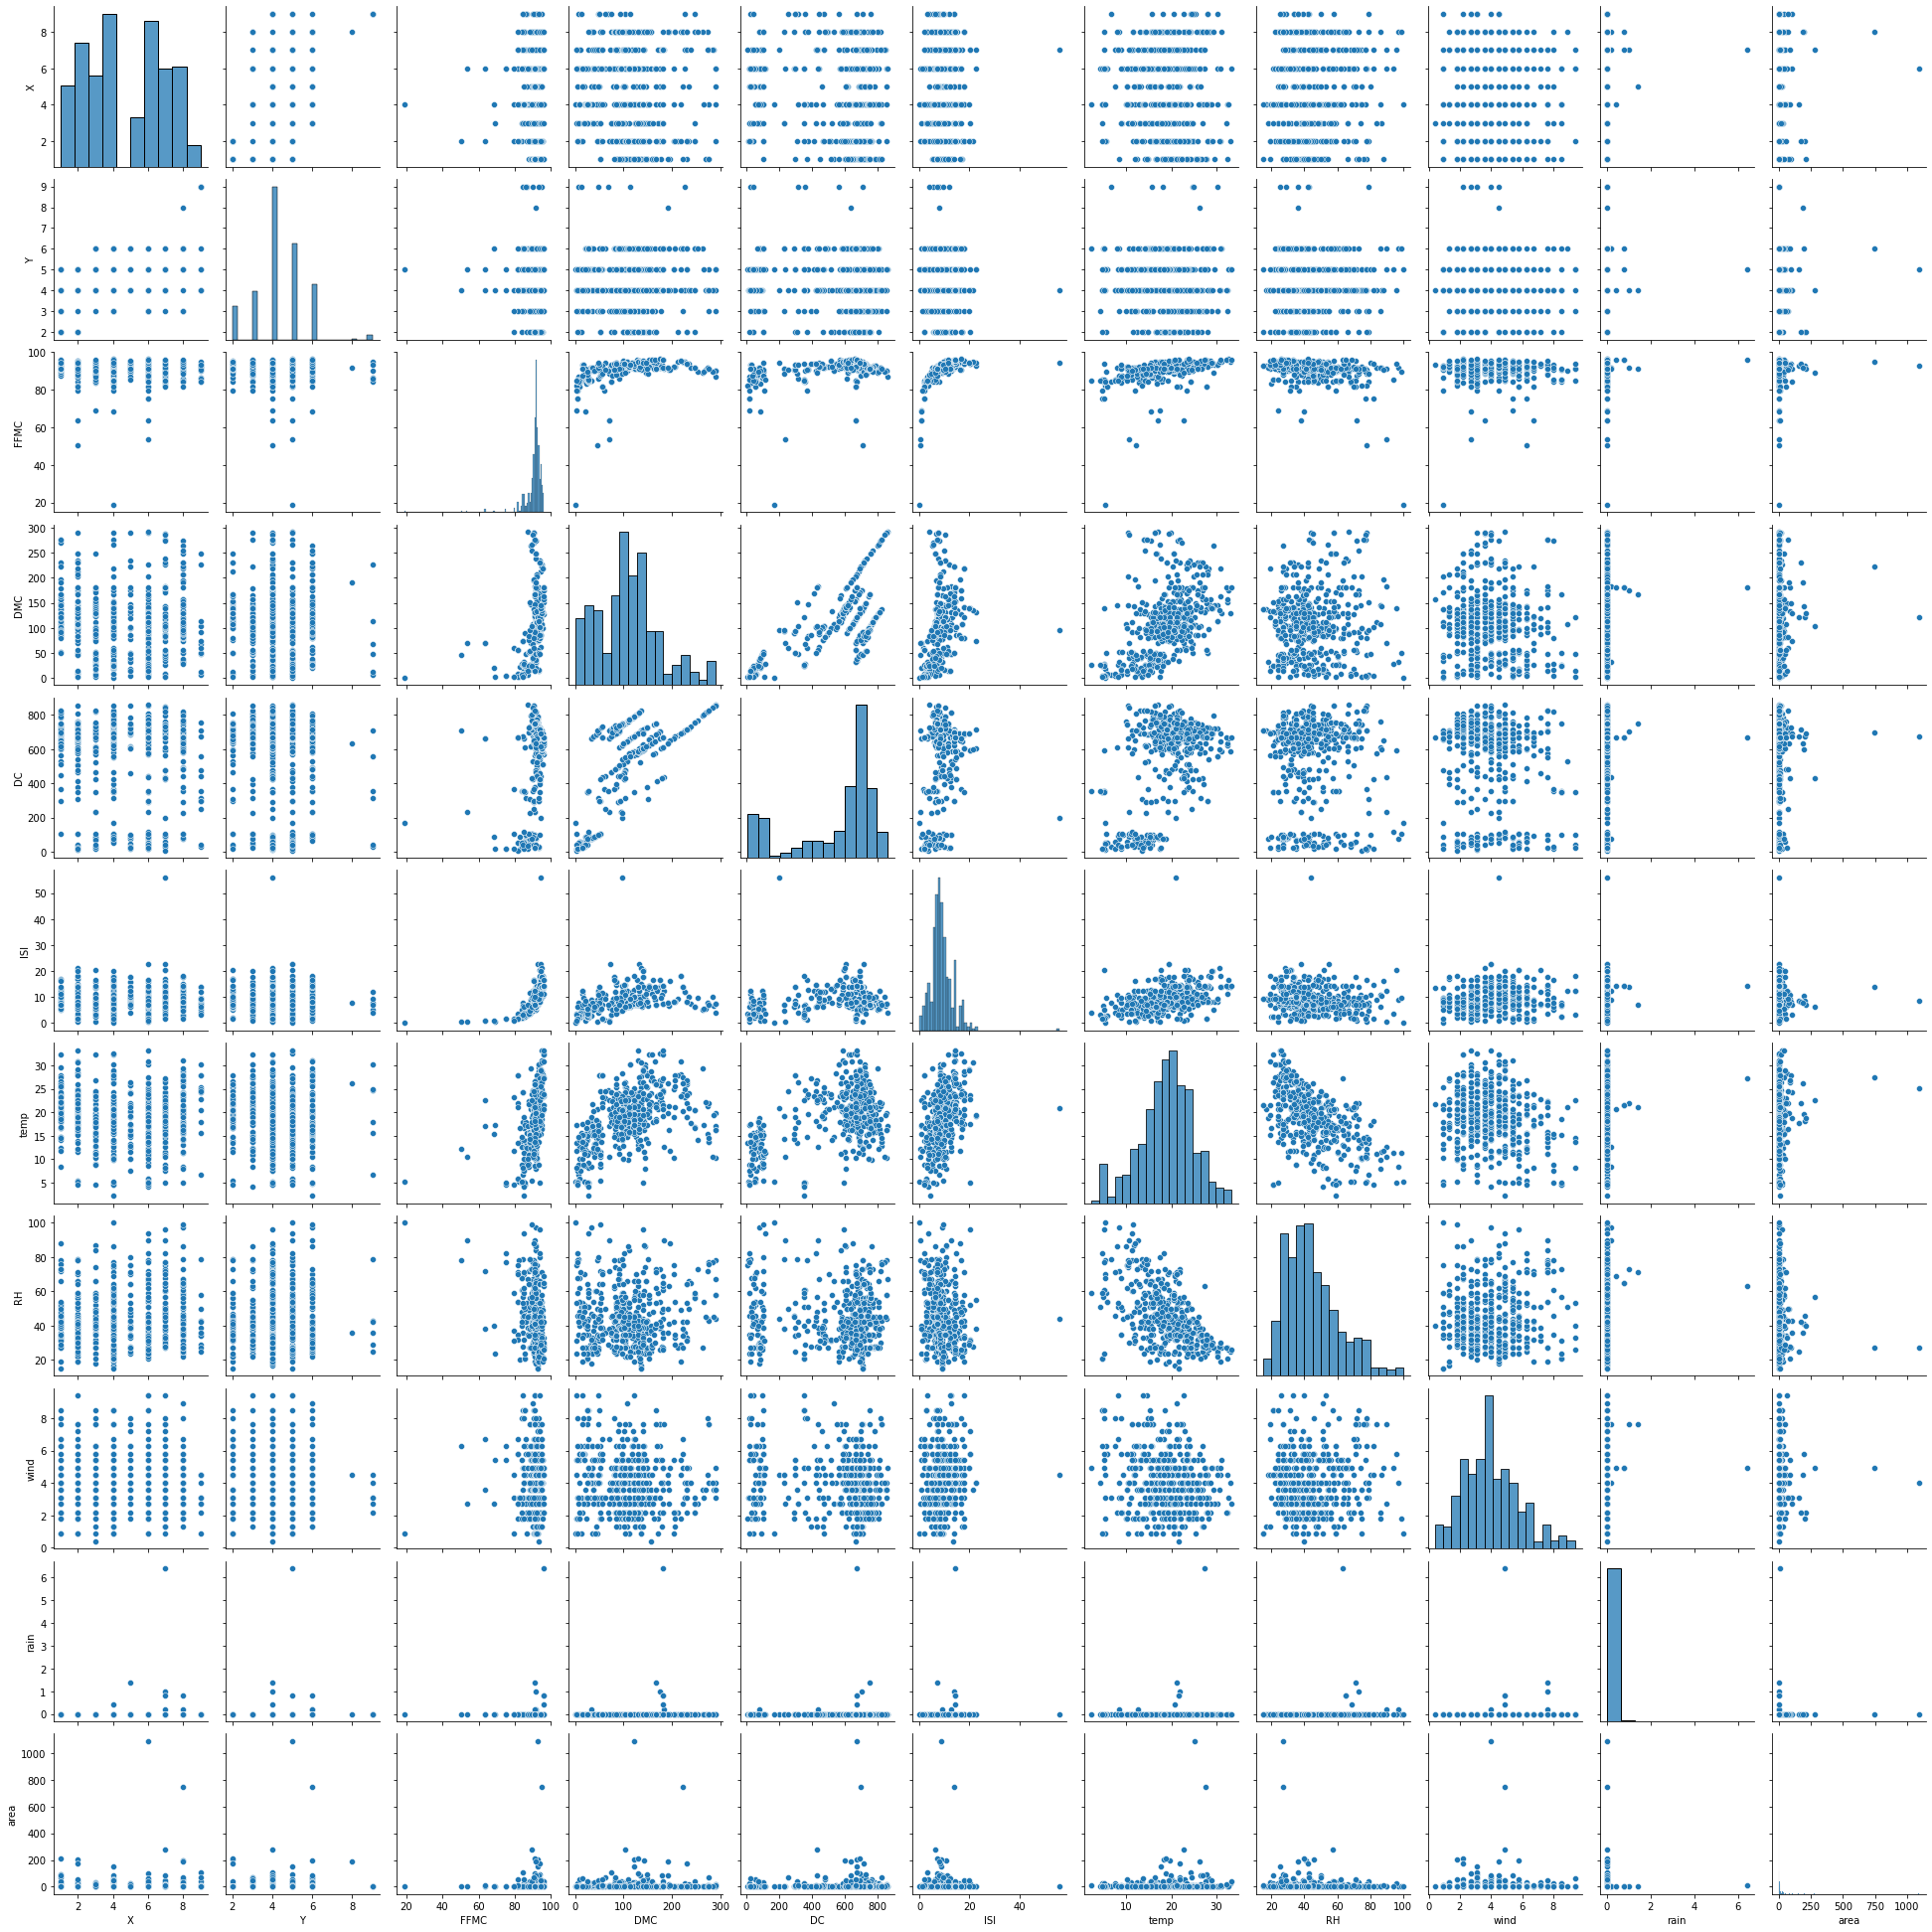

In [21]:
# Pairplot of all 13 variables
_ = sns.pairplot(ff_data, height=2.5)

In [22]:
out_columns = ['area','FFMC','ISI','rain']

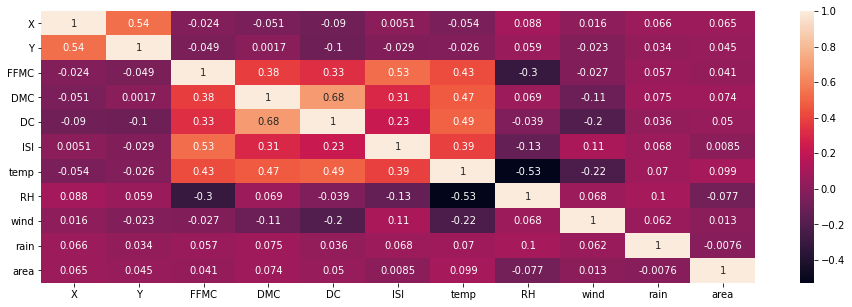

In [23]:
# Correlation matrix
_ = plt.figure(figsize=(16,5))
corrMatrix = ff_data.corr()
_ = sns.heatmap(corrMatrix, annot=True)
plt.show()

As one could expect, <i>FFMC</i>, <i>DMC</i>, <i>DC</i> and <i>ISI</i> (but interestingly also <i>temp</i>) features are positive correlated among them.<br><i>RH</i> is instead negatively correlated with <i>FFMC</i> and <i>temp</i>.

# Preparing the data for modelling

First we need to encode the categorical columns.

In [24]:
# Getting dummy variables (one-hot encoding) for 'month' and 'day'
ff_data = pd.get_dummies(ff_data,columns=['day','month'],drop_first=True)

# Ordinal encoding:
# ff_data['month'].replace(('jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'),
#                          ('1','2','3','4','5','6','7','8','9','10','11','12'), inplace=True)
# ff_data['month'] = ff_data['month'].astype(int)

# ff_data['day'].replace(('mon', 'tue', 'thu', 'wed', 'fri', 'sat', 'sun'),
#                        ('1','2','3','4','5','6','7'), inplace=True)
# ff_data['day'] = ff_data['day'].astype(int)

We retained one-hot encoding the appropriate way to solve this "encoding issue" since we have at disposal partial temporal information and we need to represent the **concept of month and day** more than the absolute temporal distance between them: in our case what matters is the relationship between the target variable and specific characteristics of certain periods (i.e. the hot season and the presence of many people due to a holiday; we already said months are an important information because of the seasonality of weather and dates are an important information because working days have less visitors than holidays).

Obviously there is a drawback: one-hot encoding of day and month feature may lead to a curse of dimensionality.

Being said that, then we data transform with $log(1 + x)$ function columns containing outliers.

In [25]:
ff_data[out_columns].describe().T

print("Skew:\n{}".format(np.log1p(ff_data[out_columns]).skew()))
print("\nKurtosis:\n{}".format(np.log1p(ff_data[out_columns]).kurtosis()))

,count,mean,std,min,25%,50%,75%,max
area,510.0,13.023627,64.074082,0.0,0.0,0.645,6.6025,1090.84
FFMC,510.0,90.635686,5.552774,18.7,90.2,91.600,92.9000,96.20
ISI,510.0,9.017059,4.571755,0.0,6.5,8.400,10.7750,56.10
rain,510.0,0.021961,0.297976,0.0,0.0,0.000,0.0000,6.40


Skew:
area     1.199645
FFMC   -11.608659
ISI     -0.938782
rain    14.076080
dtype: float64

Kurtosis:
area      0.902244
FFMC    183.236874
ISI       2.576518
rain    231.044213
dtype: float64


<i>FFMC</i> and <i>rain</i> are still having high skew and kurtosis values, since we will be using linear regression model we cannot operate with such high values. So for <i>FFMC</i> we remove the outliers using z-score method.

In [26]:
mask = ff_data.loc[:,['FFMC']].apply(zscore).abs() < 3

Since most of the values in <i>rain</i> are $0.0$, we can convert it as a categorical column.

In [27]:
ff_data['rain'] = ff_data['rain'].apply(lambda x: int(x > 0.0))

In [ ]:
ff_data = ff_data[mask.values]

In [29]:
out_columns.remove('rain')

ff_data[out_columns] = np.log1p(ff_data[out_columns])

ff_data[out_columns].describe().T
print("Skew:\n{}".format(np.log1p(ff_data[out_columns]).skew()))
print("\nKurtosis:\n{}".format(np.log1p(ff_data[out_columns]).kurtosis()))

,count,mean,std,min,25%,50%,75%,max
area,503.0,1.136956,1.404855,0.000000,0.000000,0.536493,2.043713,6.995620
FFMC,503.0,4.522578,0.035133,4.332048,4.514151,4.529368,4.542230,4.576771
ISI,503.0,2.227752,0.429796,0.741937,2.041220,2.240710,2.484907,4.044804


Skew:
area    0.471735
FFMC   -1.836167
ISI    -1.038116
dtype: float64

Kurtosis:
area   -1.239736
FFMC    5.019070
ISI     1.960375
dtype: float64


We will use this dataframe for building our ML model.

In [30]:
ff_data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,503.0,4.662028,2.321107,1.000000,3.000000,4.000000,7.000000,9.000000
Y,503.0,4.292247,1.236915,2.000000,4.000000,4.000000,5.000000,9.000000
FFMC,503.0,4.522578,0.035133,4.332048,4.514151,4.529368,4.542230,4.576771
DMC,503.0,111.790060,63.910094,3.000000,73.300000,108.400000,142.400000,291.300000
DC,503.0,550.483897,247.224332,7.900000,441.500000,664.200000,714.300000,860.600000
ISI,503.0,2.227752,0.429796,0.741937,2.041220,2.240710,2.484907,4.044804
temp,503.0,18.943340,5.804311,2.200000,15.600000,19.300000,22.850000,33.300000
RH,503.0,44.089463,16.008276,15.000000,33.000000,42.000000,53.000000,99.000000
wind,503.0,4.008350,1.791027,0.400000,2.700000,4.000000,4.900000,9.400000
rain,503.0,0.015905,0.125231,0.000000,0.000000,0.000000,0.000000,1.000000


# ML model

In [31]:
# Split X and y (multivariate regression problem := 27 variables, 1 output)
X = ff_data.drop(columns=[target]).to_numpy() # X := all the columns except 'area', the target
y = ff_data[target].to_numpy() # y := only target ('area') column

print("X.shape", X.shape, "X.dtype", X.dtype)
print("y.shape", y.shape, "y.dtype", y.dtype)

X.shape (503, 27) X.dtype float64
y.shape (503,) y.dtype float64


## Split data

We can now split data into training and test sets.

In [32]:
ff_test_size = 0.15 # 85% of data --> training set; 15% of data --> testing set
ff_test_seed = 3

# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ff_test_size, random_state=ff_test_seed)

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

X_train.shape (427, 27)
X_test.shape (76, 27)


## Linear Regression

In [33]:
# Build model + Model fitting
model = LinearRegression(fit_intercept=True).fit(X_train, y_train)

# Prediction
y_predict_test = model.predict(X_test)
y_predict_train = model.predict(X_train)

# Model evaluation
print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.08652144162789432
Train MSE score  1.6795525646010767
Test R2 score  0.012746785399549432
Test MSE score  2.6414169879229865


$R^2$ scores should ideally be close to $1$. Let's do some feature selection by checking p-values to decide whether to keep the column or drop it.

In [34]:
# Split X and y
X = ff_data.drop(columns=[target]) # X := all the columns except 'area', the target
y = ff_data[target] # y := only target ('area') column

# Add intercept
X_constant = sm.add_constant(X)

def check_stats(X,y):
    # Build model + Model fitting
    lin_reg = sm.OLS(y,X).fit()
    print(lin_reg.summary(),
          "\nSorted p-values:",
          lin_reg.summary2().tables[1]['P>|t|'].sort_values(ascending=False), sep='\n')
    
check_stats(X_constant,y)

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.538
Date:                Mon, 02 May 2022   Prob (F-statistic):             0.0427
Time:                        19:03:26   Log-Likelihood:                -863.14
No. Observations:                 503   AIC:                             1782.
Df Residuals:                     475   BIC:                             1900.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8284     18.414      0.045      0.9

The p-value for some features is very high, meaning that we had not enough statistical evidence to reject the null hypothesis (we have no evidence to say that these features, alone, are correlated with the observation).

Let's first of all remove <i>const</i> (intercept term).

In [35]:
check_stats(X,y)

                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.445
Model:                            OLS   Adj. R-squared (uncentered):              0.413
Method:                 Least Squares   F-statistic:                              14.12
Date:                Mon, 02 May 2022   Prob (F-statistic):                    2.76e-45
Time:                        19:03:26   Log-Likelihood:                         -863.14
No. Observations:                 503   AIC:                                      1780.
Df Residuals:                     476   BIC:                                      1894.
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Just by dropping constant we got a huge bump in $adjusted$ $R^2$ from $2.8\%$ to $41.3\%$.<br>
Moreover, $F$-$statistic$ bumped from $1.538$ to $14.12$. Equivalently, $Prob(F$-$statistic)$ went from $0.0427$ to $2.76e^{-45}$.

In [36]:
features = ['FFMC', 'day_thu', 'month_jul', 'Y', 'month_feb', 'day_mon', 'month_may',
            'day_wed', 'day_sun', 'month_jan', 'ISI', 'month_aug']

for feature in features :
    X.drop(columns=feature,inplace=True)
    # check_stats(X,y)
    
check_stats(X,y)    

                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.441
Model:                            OLS   Adj. R-squared (uncentered):              0.424
Method:                 Least Squares   F-statistic:                              25.68
Date:                Mon, 02 May 2022   Prob (F-statistic):                    2.17e-52
Time:                        19:03:26   Log-Likelihood:                         -864.78
No. Observations:                 503   AIC:                                      1760.
Df Residuals:                     488   BIC:                                      1823.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Similarly, we can continue to optimize the model (i.e. remove not so necessary features checking their p-value). Our $adjusted$ $R^2$ score has improved from $2.8\%$ to $42.4\%$. 

$F$-$statistic$ has improved from $1.538$ to $25.68$. Equivalently, $Prob$ $(F$-$statistic)$ has improved from $1.538$ to $2.17e^{-52}$, therefore the model has become more significant.

Let's perform an F-test to check if the subset of all these discarded features, combined, is informative to perform a good prediction.

In [37]:
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def tss(y):
    return np.sum((y - y.mean()) ** 2)

def multiple_least_squares(X, y):
    # Helper function that uses scikit-learn models
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred
 
# H0: all features in the subset are equal to 0    
def Ftest_restricted(data, y, subset_features):
    # Train the complete model
    X_complete = data.to_numpy()
    y = y.to_numpy()
    n = X_complete.shape[0]
    
    betas_complete, y_pred = multiple_least_squares(X_complete, y)    
    rss_complete = rss(y, y_pred)
    nf_complete = X_complete.shape[1]
    
    # Train the restricted model
    notS = data.columns.difference(subset_features)
    X_restr = data[notS].to_numpy()
    betas_restr, y_pred = multiple_least_squares(X_restr, y)

    rss_restr = rss(y, y_pred)
    nf_restr = X_restr.shape[1]

    q = nf_complete - nf_restr

    # Compute F statistics
    F_num = (rss_restr - rss_complete) / q
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den

    # Compute the p-value
    p_value = f.sf(F, q, n - nf_complete - 1)
    return p_value, F

In [38]:
alpha = 0.05

X_all_features = list(ff_data.columns.values)
X_all_features.remove(target)

# The Ftest_restricted function expect an input data that is a Pandas
# array (since it will use strings to select the restricted model's features)
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
y_train_pd = pd.DataFrame(y_train)

p_value, F = Ftest_restricted(X_train_pd, y_train_pd, features)
print("p-value =", p_value)
print("F-stat =", F)
if p_value < alpha:
    print("Reject H0: There evidence to say that at least one of the S features is useful")
else:
    print("Do not Reject H0: There is NO evidence to say that at least one of the S features is useful")

p-value = 0.9358574156080297
F-stat = 0.46226341364457535
Do not Reject H0: There is NO evidence to say that at least one of the S features is useful


Since F-statistic is $<1$ and the p-value is quite high, we refuse to reject the null hypothesis.

In [39]:
X_features = ['month_nov', 'RH', 'month_mar', 'day_tue', 'month_oct', 'day_sat', 'wind',
              'rain', 'X', 'month_sep', 'DC', 'DMC', 'temp', 'month_dec']
X = ff_data[X_features].to_numpy()
y = ff_data[target].to_numpy()

ff_test_seed_v2=3
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y,
                                                                test_size=ff_test_size, 
                                                                random_state=ff_test_seed_v2)

model = LinearRegression(fit_intercept=False) # We already discovered intercept is not significant                       
model = model.fit(X_train_small, y_train_small)       
y_predict_test = model.predict(X_test_small)     
y_predict_train = model.predict(X_train_small)


print("Train R2 score ", r2_score(y_train_small, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train_small, y_predict_train))

print("Test R2 score ", r2_score(y_test_small, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test_small, y_predict_test))

Train R2 score  0.07047732972587117
Train MSE score  1.7090518112389084
Test R2 score  0.045777726375246464
Test MSE score  2.553042002326614


Full model:<br>
Train $R^2$ score  $0.08652144162789432$<br>
Train $MSE$ score  $1.6795525646010767$<br>
Test $R^2$ score  $0.012746785399549432$<br>
Test $MSE$ score  $2.6414169879229865$

We reduced a little the $R^2$ and $MSE$ train performances, but we gained in $R^2$ and $MSE$ test performances (which is our aim: the model needs to perform well on new "unseen before" data).

## Polynomial regression

One common way to increase the expressive power of linear models is to transform features using non-linear functions. One option is to construct polynomial features from the coefficients; we'll construct a **second degree polynomial**.

In [40]:
# Transform each feature into polynomial features based on the degree.
# Eg: in case of degree 2 we have the original features plus the product
# of each pair of features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly = poly.fit(X_train_small)

# Apply the transformation
X_train_poly = poly.transform(X_train_small)
X_test_poly = poly.transform(X_test_small)

print("X_train_small.shape", X_train_small.shape, " X_poly_train.shape", X_train_poly.shape)
print("X_test_small.shape", X_test_small.shape, " X_poly_train.shape", X_test_poly.shape)

X_train_small.shape (427, 14)  X_poly_train.shape (427, 119)
X_test_small.shape (76, 14)  X_poly_train.shape (76, 119)


Polynomial Regression takes into account squared and interaction terms (known as **synergistic effect** in marketing), which in our framework could be interesting. Here we show some variables for example.

In [41]:
X_train_small_pd = pd.DataFrame(X_train_small, columns=X_features)
# Some features of the polynomial model
print(poly.get_feature_names_out(X_train_small_pd.columns)[14:18])

['month_nov^2' 'month_nov RH' 'month_nov month_mar' 'month_nov day_tue']


In [42]:
# Build model + Model fitting
model = LinearRegression(fit_intercept=True).fit(X_train_poly, y_train)

# Prediction
y_predict_test = model.predict(X_test_poly)
y_predict_train = model.predict(X_train_poly)

# Model evaluation
print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.20107043058199714
Train MSE score  1.4689389202992547
Test R2 score  -0.001263425861514289
Test MSE score  2.6789016063390845


Small Features Model:<br>
Train $R^2$ score  0.07047732972587117<br>
Train $MSE$ score  1.7090518112389084<br>
Test $R^2$ score  0.045777726375246464<br>
Test $MSE$ score  2.553042002326614<br>

Full model:<br>
Train $R^2$ score  0.08652144162789432<br>
Train $MSE$ score  1.6795525646010767<br>
Test $R^2$ score  0.012746785399549432<br>
Test $MSE$ score  2.6414169879229865

It's interesting seeing that train $R^2$ and $MSE$ score improved (particularly $R^2$ score bumped from $0.07$ to $0.20$ which is a good gain), but test $R^2$ got worse (even a little bit lower than $0$, which is a bad result). We can conclude that a second degree polynomial model causes **overfitting** of data.

Best model seems to be the linear one; let's see if this assumption can be confirmed.

### Hyperparameters selection

Let's first try to implement a hold-out validation ourself.

In [43]:
# Split the previous training set into two sets: train + validation
# In this case we create a validation set having the same size of the test set
ff_test_seed_v3=4
X_trainR_small, X_val_small, y_trainR, y_val = train_test_split(X_train_small, y_train_small, 
                                                                test_size=y_test.shape[0],
                                                                random_state=ff_test_seed_v3)

We execute the same validation code as before, however we use the validation set, instead of the test set, to compute the performance of our model. We keep track of the best degree paramenter on the validation set, finally we train again the model using the best degree parameter and all the training samples (train+validation). Finally, we compute the performance on the test set.

In [44]:
degree = list(range(1,5))
test_scores = np.zeros(len(degree))
val_scores = np.zeros(len(degree))
train_scores = np.zeros(len(degree))

# Validation
for i, d in enumerate(degree):
    
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    
    model = model.fit(X_trainR_small, y_trainR)
    
    y_predict = model.predict(X_val_small)
    val_score = r2_score(y_val, y_predict)
    y_predict = model.predict(X_test_small)
    test_score = r2_score(y_test_small, y_predict)
    y_predict = model.predict(X_trainR_small)
    train_score = r2_score(y_trainR, y_predict)
    
    val_scores[i] = val_score
    test_scores[i] = test_score
    train_scores[i] = train_score

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(X_train_small, y_train_small)
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Test score:", test_score)

Best degree:  1 
Val score:  0.0877817552282868
Test score: 0.04030054748863454


Best degree = $1$ confirms the fact that a linear model is the best one.

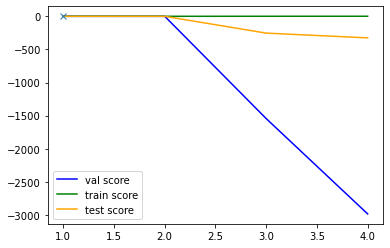

In [45]:
_ = plt.plot(degree,val_scores, label="val score", color="blue")
_ = plt.plot(degree, train_scores, label="train score", color="g")
_ = plt.plot(degree, test_scores, label="test score", color="orange")
_ = plt.plot([best_degree], [best_val_score], marker="x")
_ = plt.legend()

And this plot confirms the overfitting hypothesis under polynomial models: train scores distant from validation and test ones (and this fact is highlighted increasing the polynomial degree of the model under analysis).

# Cross Validation

To select the best hyper-parameters that work well over most datasets (i.e., small variations of the dataset), we can simulate to have multiple training and validation sets (**folds**). We iteratively reserve a part of the training set for validation and train the model on the remaining data. <br>The overall validation score is the average score on all the validation sets.

## The `cross_val_score` method

The `sklearn` package provides the `cross_val_score` function to perform model evaluation. The function, given a dataset, automatically:
- splits it into different folds
- trains the model on the training folds
- evaluate the model on the validation folds
- return as a result the validation scores computed on each split

With the `scoring` argument we can control which metric is applied each time to compute the validation scores.

Best degree:  1 
Val score:  0.00428803975960892
Test score: 0.04030054748863454


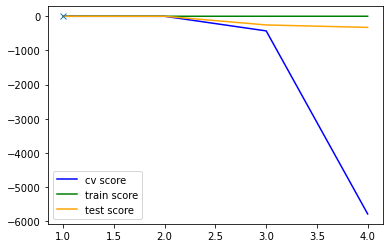

In [46]:
# NOTE: same code as before, we just changed the way we
# compute the validation score. Instead on a single fold,
# we use a cross validation score for each possibility!
# Look at how 'val_score' is computed!
# NOTE: We don't need to explicitely train the model, the
# function will do it for us for each train split. Also
# train scores are not reported, only the cv score!
# ======================================================

# NOTE: The API always maximises the score, so score that
# must be minimized are retured as negative values!
r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)
# or ...
# mse_scorer = 'neg_mean_squared_error'

degree = list(range(1,5))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train_small, y_train_small, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train_small]), np.concatenate([y_train_small]))
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Test score:", test_score)

_ = plt.plot(degree, val_scores, label="cv score", color="blue")
_ = plt.plot(degree, train_scores, label="train score", color="green")
_ = plt.plot(degree, test_scores, label="test score", color="orange")
_ = plt.plot([best_degree], [best_val_score], marker="x")
_ = plt.legend()

K-fold CV method makes it even more evident: using a polynomial model we incur in overfitting of data.

## The `GridSearchCV` class

The `GridSearchCV` class performs cross validation while also searching among a set of different hyperparameters. We can substitute all the previous for loop on the degree variable with a single `GridSearchCV.fit()` call! We will obtain the same results!

In [47]:
# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train_small, y_train_small)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

In [48]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000967,0.000278,0.000404,0.000116,1,{'poly__degree': 1},-0.039486,0.075686,0.029036,-0.097956,0.054160,0.004288,0.064137,1
1,0.002126,0.000122,0.000505,0.000020,2,{'poly__degree': 2},-0.419827,-1.396738,-0.141330,-0.940137,-0.874011,-0.754409,0.435706,2
2,0.011022,0.001013,0.000779,0.000084,3,{'poly__degree': 3},-37.610978,-171.710744,-437.555553,-1184.875941,-308.297025,-428.010048,401.340023,3
3,0.028799,0.003853,0.001247,0.000009,4,{'poly__degree': 4},-574.834495,-667.903849,-479.954625,-25998.386979,-1209.537178,-5786.123425,10109.301370,4


In [49]:
# Retrieve the best **trained** estimator
model = cv.best_estimator_
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Best degree:", cv.best_params_['poly__degree']) # Retrieve its parameters
print("Train score:", cv.best_score_) # Retrieve the best **CV** score; i.e., mean of the scores on each fold
print("Test score:", test_score)

Best degree: 1
Train score: 0.00428803975960892
Test score: 0.04030054748863454


Getting the same previous results obtained by implementing the loop from scratch.

# Forward Feature Selection

**Best Feature Subset Selection** algorithm always finds the best solution. However, we have $p = 27$ features: an exhaustive esploration of model space would lead to $2^p = 2^{27} = 134,217,728$ possible input combination, which is unfeasible. We omit running it, but leave the code here for completeness.

A better strategy that involves computing fewer models, while achieving similar results, is the **Forward Feature Selection**: we move from a $2^p$ (exponential) to an $O(p^2)$ (quadratic) computational complexity. However, the drawback is that we are using a greedy algorithm that provides no guarantee of finding the best solution (might end up in a suboptimal subset).

Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model. We added cross-validation to our algorithm implementation.

In [50]:
# Convert back from numpy arrays to data frames just for convenience,
# since we can use names to index features
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

In [51]:
import itertools
def get_subsets(X_pd, dim):
    feature_names = X_pd.columns.tolist()
    # Compute all possibile combinations of 'dim' values
    subset_names = itertools.combinations(feature_names, dim) # list of list of names
                                                              # [[name of first candidate, ...], [...]]
    # Convert names into datasets
    data_subsets = [X_pd[list(fnames)] for fnames in subset_names]
    return data_subsets

subsets = get_subsets(X_train_pd, 1)
subsets[0].head() # training set of the first subset
subsets[1].head() # training set of the second subset

,X
0,2.0
1,7.0
2,2.0
3,1.0
4,1.0


,Y
0,2.0
1,4.0
2,4.0
3,2.0
4,4.0


In [52]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator    

In [53]:
from sklearn.dummy import DummyRegressor

def subset_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                     candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                     subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                     test_evaluator=None, test_argbest=None, # Metric to be used on the test set
                     candidates_scorer_name=None,  # Name of 2. figure
                     subsets_scorer_name=None,     # Name of 3. figure
                     verbose=True, weight_step3=0):  
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = [] 
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A counter to keep track of the total number of trials
    
    # 1. and 2. Evaluate all Mk candidates with
    #           k=0...p features
    # =========================================
    for dim in range(num_features+1):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        dim_subsets = get_subsets(Xtrain_pd, dim=dim)
        for Xtrain_sub in dim_subsets:
            
            # Train the model on the subset
            if Xtrain_sub.shape[-1] == 0:
                # 1. Train the M0 model if the number of
                #    features is zero!
                # ======================================
                model = DummyRegressor()
            else:
                model = LinearRegression(fit_intercept=True)
            
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([dim]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Save best candidate features
        best_features = dim_subsets[idx_best_candidate].columns.tolist()
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = dim_subsets[idx_best_candidate]
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_subset_Xtrain.columns.tolist()]
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how the 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

In [54]:
def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))

In [55]:
def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

sigma = estimate_sigma(X_train_pd, y_train)

In [56]:
%%script false --no-raise-error

subset_selection(X_train_pd, y_train, X_test_pd, y_test,
                 get_evaluator(make_scorer(rss)), np.argmin, # 2.
                 get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                 candidates_scorer_name="RSS",
                 subsets_scorer_name="BIC",
                 verbose=True)

In [57]:
def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...p features
    # =========================================
    # The loop condition is slightly changed
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()
    
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=mpg_test_seed)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

............
Best model (M0) with 0 features: ['month_dec']
M0 subset score (3.): 0.0013110380095578966
............
Best model (M1) with 1 features: ['month_dec', 'temp']
M1 subset score (3.): 0.010851572178997237
............
Best model (M2) with 2 features: ['month_dec', 'temp', 'month_sep']
M2 subset score (3.): 0.013822950829784575
............
Best model (M3) with 3 features: ['month_dec', 'temp', 'month_sep', 'wind']
M3 subset score (3.): 0.004647092256205632
............
Best model (M4) with 4 features: ['month_dec', 'temp', 'month_sep', 'wind', 'day_sat']
M4 subset score (3.): 0.0020402575654024924
............
Best model (M5) with 5 features: ['month_dec', 'temp', 'month_sep', 'wind', 'day_sat', 'month_feb']
M5 subset score (3.): 0.0006757401720586254
............
Best model (M6) with 6 features: ['month_dec', 'temp', 'month_sep', 'wind', 'day_sat', 'month_feb', 'X']
M6 subset score (3.): 0.017630192803360867
............
Best model (M7) with 7 features: ['month_dec', 'temp',

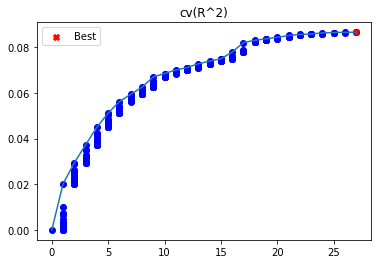

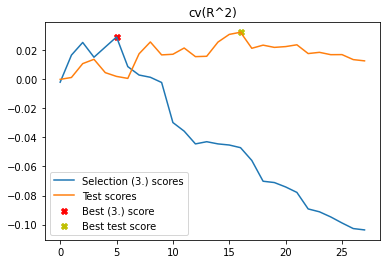

In [58]:
cv = 5
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score)), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

We found that the best configuration according to Forward Feature Selection algorithm has the subsequent $5$ features: <i>month_dec</i>, <i>temp</i>, <i>month_sep</i>, <i>wind</i> and <i>day_sat</i>. Interestingly, <i>month_sep</i> and <i>day_sat</i> are two of the, respectively, months and days with most fires.

An alternative that avoids our algorithm implementation from scratch is the `mlxtend.feature_selection.SequentialFeatureSelector`. Unfortunately, you need to provide a priori a $K$ number of features (`k_feature` parameter). 

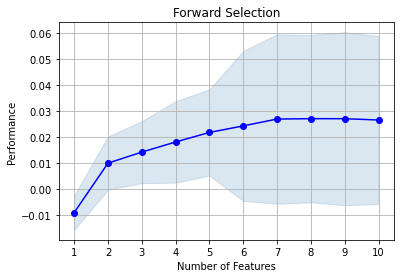

In [108]:
X = ff_data.drop(columns=[target])
y = ff_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ff_test_size, random_state=ff_test_seed)

model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=10,forward=True,scoring='r2',cv=cv).fit(X_train,y_train)
_ = plot_sfs(sfs1.get_metric_dict())
_ = plt.title('Forward Selection')
_ = plt.grid()
_ = plt.show()

In [60]:
print("Selected features for K = ", sfs1.k_features, ":\n", sfs1.k_feature_names_, sep='')

Selected features for K = 10:
('FFMC', 'temp', 'wind', 'rain', 'day_sat', 'day_tue', 'month_dec', 'month_jan', 'month_mar', 'month_nov')


In [61]:
index = list(sfs1.k_feature_idx_)
X_train_ = X_train.iloc[:,index]
X_test_ = X_test.iloc[:,index]

model = LinearRegression().fit(X_train_,y_train)

y_predict_test = model.predict(X_test_)
y_predict_train = model.predict(X_train_)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.05323051487097652
Train MSE score  1.740762388192526
Test R2 score  0.007487262105348114
Test MSE score  2.6554889544379834


# Backward Feature Selection

**Backward Feature Selection** is another greedy algorithm that has the same (more or less) computational complexity as Forward one. However, it can not be used when $n<p$ (not our case).

In backward selection, we start with all the features and remove the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.

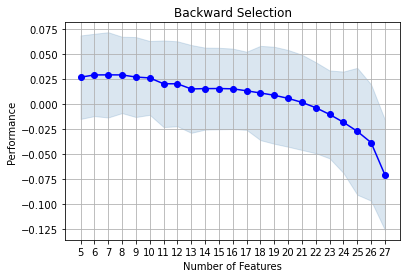

In [62]:
model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=5,forward=False,scoring='r2',cv=cv).fit(X_train,y_train)
_ = plot_sfs(sfs1.get_metric_dict())
_ = plt.title('Backward Selection')
_ = plt.grid(True)
plt.show()

In [63]:
print("Selected features for K = ", sfs1.k_features, ":\n", sfs1.k_feature_names_, sep='')

Selected features for K = 5:
('temp', 'wind', 'rain', 'day_sat', 'month_dec')


Our Forward Feature Selection implementation previously found: <i>month_dec</i>, <i>temp</i>, <i>month_sep</i>, <i>wind</i> and <i>day_sat</i>.<br><i>month_sep</i> feature was substituted by <i>rain</i> feature, but the others remain the same. 

In [64]:
index = list(sfs1.k_feature_idx_)
X_train_ = X_train.iloc[:,index]
X_test_ = X_test.iloc[:,index]

model = LinearRegression().fit(X_train_,y_train)

y_predict_test = model.predict(X_test_)
y_predict_train = model.predict(X_train_)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.04500912136592494
Train MSE score  1.755878520278441
Test R2 score  0.0021636004890961402
Test MSE score  2.6697325243987176


Forward Feature Selection ($K = 10$):<br>
Train $R^2$ score  $0.05323051487097652$<br>
Train $MSE$ score  $1.740762388192526$<br>
Test $R^2$ score  $0.007487262105348114$<br>
Test $MSE$ score  $2.6554889544379834$

In our context, `feature_selection.SequentialFeatureSelector` with parameter `forward=False` or `forward=True` leads to similar results in terms of $R^2$ and $MSE$.

# Ridge Regression

**Ridge Regression** shrinks down parameters with **L2 normalization**. The tuning parameter $\lambda$ must be find using cross-validation.

In [65]:
# Higher the alpha value, more restriction on the coefficients; 
# lower the alpha, more generalization
rr = RidgeCV(cv=cv,fit_intercept=False).fit(X_train, y_train)
print("Coefficient of determination of the prediction:", rr.score(X_train,y_train))

Coefficient of determination of the prediction: 0.06271298450372687


In [66]:
# Features' coefficients
[(X_all_features[i], rr.coef_[i]) for i in range(len(X_all_features))]

[('X', 0.029055068135806286),
 ('Y', 0.01866897935090333),
 ('FFMC', 0.022419652897558852),
 ('DMC', 0.0014933770268185432),
 ('DC', -0.00034897573285048273),
 ('ISI', -0.09247297145902517),
 ('temp', 0.02480930064579077),
 ('RH', 0.0010480937476980486),
 ('wind', 0.09864632244007762),
 ('rain', -0.30415321265262857),
 ('day_mon', 0.038002171312831325),
 ('day_sat', 0.2894663986384685),
 ('day_sun', 0.12583437735116823),
 ('day_thu', -0.029902884722086603),
 ('day_tue', 0.15113448804051582),
 ('day_wed', 0.14009362400018274),
 ('month_aug', -0.10202370376566881),
 ('month_dec', 0.6354135198964423),
 ('month_feb', 0.12187568231764642),
 ('month_jan', -0.0833471818507008),
 ('month_jul', -0.2098911576361607),
 ('month_jun', -0.1683408818639478),
 ('month_mar', -0.24968493357440644),
 ('month_may', 0.10840487525435724),
 ('month_nov', -0.10433085564265128),
 ('month_oct', 0.04377359771859962),
 ('month_sep', 0.23788622811190577)]

As we can see features' coefficients are close to $0$, but never equal to $0$. Lasso (see next paragraph) instead sets coefficients to $0$, therefore performing feature selection.

In [67]:
print("The amount of penalization chosen by cross validation is", rr.alpha_)

The amount of penalization chosen by cross validation is 10.0


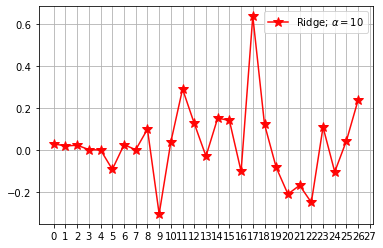

In [68]:
_ = plt.plot(rr.coef_,alpha=10,marker='*',markersize=10,color='red',label=r'Ridge; $\alpha =10$') 
_ = plt.grid(True)
_ = plt.xticks(range(0,28,1))
_ = plt.legend()
_ = plt.show()

In [69]:
y_predict_test = rr.predict(X_test)
y_predict_train = rr.predict(X_train)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.06271298450372687
Train MSE score  1.723327598897833
Test R2 score  0.024876306152446848
Test MSE score  2.608964196989271


Which is the best result until now.

# Feature selection with Lasso

**Lasso** works by adding an **L1-norm** term. By gradually increasing the $\lambda$ parameter (i.e., increasing the sparsity of the model), the parameters that go to zero first will likely be the least important ones. 

Therefore, Lasso performs variable selection.

In [102]:
lr = LassoLarsCV(fit_intercept=False,cv=cv,normalize=True).fit(X_train, y_train) # Cross-validated Lasso, using the LARS algorithm
print("Coefficient of determination of the prediction:", lr.score(X_train,y_train))

Coefficient of determination of the prediction: 0.07610625664676951


In [103]:
# Features' coefficients != 0
print(np.sum(lr.coef_ != 0), 'coefficients != 0; they are:')
[(X_all_features[i], lr.coef_[i]) for i in range(len(X_all_features)) if lr.coef_[i] != 0]

21 coefficients != 0; they are:


[('X', 0.03468978188156541),
 ('FFMC', -0.08265660564908743),
 ('DMC', 0.001992817322675499),
 ('DC', -0.0008284454138079406),
 ('ISI', -0.030657976317849302),
 ('temp', 0.041857625889600944),
 ('RH', 0.005519618830758431),
 ('wind', 0.08169176700013643),
 ('rain', -0.633209232277276),
 ('day_mon', 0.008058957863597248),
 ('day_sat', 0.3135112790634138),
 ('day_sun', 0.11383231724781973),
 ('day_tue', 0.17430671825266755),
 ('day_wed', 0.14185529749028214),
 ('month_dec', 1.7349198816495104),
 ('month_feb', 0.214855370206405),
 ('month_jul', -0.1945876037535772),
 ('month_jun', -0.1791262660539737),
 ('month_mar', -0.1720782087930033),
 ('month_oct', 0.28134120163359094),
 ('month_sep', 0.4578527976113275)]

As said before, Lasso performs feature selection by setting features' coefficients to $0$.

In [104]:
print("The amount of penalization chosen by cross validation is", lr.alpha_)

The amount of penalization chosen by cross validation is 0.00322339955260076


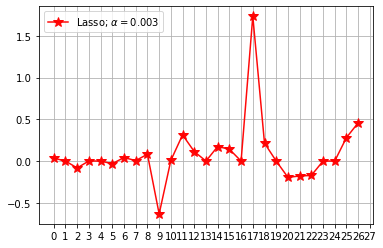

In [105]:
_ = plt.plot(lr.coef_,alpha=10,marker='*',markersize=10,color='red',label=r'Lasso; $\alpha =0.003$') 
_ = plt.grid(True)
_ = plt.xticks(range(0,28,1))
_ = plt.legend()
_ = plt.show()

In [106]:
y_predict_test = lr.predict(X_test)
y_predict_train = lr.predict(X_train)

print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.07610625664676951
Train MSE score  1.6987022758729171
Test R2 score  0.03199377222012001
Test MSE score  2.589921265040221


Ridge Regression:<br>
Train $R^2$ score  $0.06271298450372687$<br>
Train $MSE$ score  $1.723327598897833$<br>
Test $R^2$ score  $0.024876306152446848$<br>
Test $MSE$ score  $2.608964196989271$

Lasso performs a little better than Ridge both in train and test sets in terms of $R^2$.<br>$MSE$s are a little bit lower too.